**IMPORTING LIBRARIES**

In [1]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import numpy as np
import pandas as pd
!pip install text_hammer
import text_hammer as th
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict
#%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from transformers import AutoTokenizer,TFBertModel

max_len = 36

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

from nltk.corpus import stopwords
from wordcloud import WordCloud

     |████████████████████████████████| 115 kB 906 kB/s            
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.10.0
    Uninstalling beautifulsoup4-4.10.0:
      Successfully uninstalled beautifulsoup4-4.10.0


2022-10-06 19:35:35.857129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 19:35:35.858296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 19:35:35.858925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


**LOADING THE DATA:**

In [2]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('../input/nlp-getting-started/test.csv',usecols=['id','text'])
sample_data = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [3]:
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_data.shape

(7613, 3)

In [6]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [7]:
train_cleaned_data = text_preprocessing(train_data,'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [8]:
train_cleaned_data[train_cleaned_data.target == 0]

,id,text,target
15,23,whats up man,0
16,24,i love fruits,0
17,25,summer is lovely,0
18,26,my car is so fast,0
19,28,what a goooooooaaaaaal,0
...,...,...,...
7581,10833,engineshed great atmosphere at the british lio...,0
7582,10834,cramer igers 3 words that wrecked disneys stoc...,0
7584,10837,these boxes are ready to explode exploding kit...,0
7587,10841,sirens everywhere,0


In [9]:
train_data = train_cleaned_data.copy()

In [10]:
train_data.head(10)

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update california hwy 20 closed in b...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,im on top of the hill and i can see a fire in ...,1
8,14,theres an emergency evacuation happening now i...,1
9,15,im afraid that the tornado is coming to our area,1


Here, 

* Target 1 indicates any accident or disaster 

* Target 0 indicates a formal tweets with not much attention


**WORD CLOUD:**

In [11]:
stop_words = set(stopwords.words('english'))
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

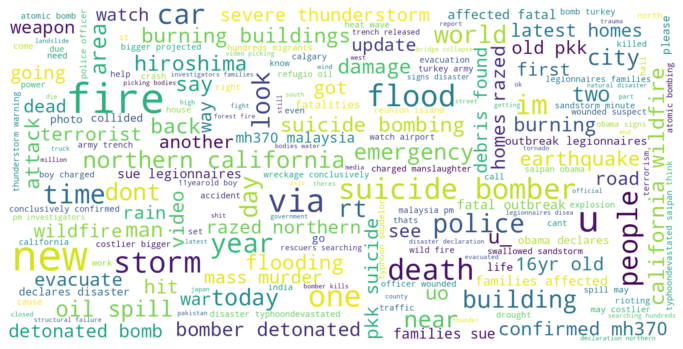

In [12]:
#Disaster Tweets wordcloud 
disaster_tweets = train_data[train_data.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

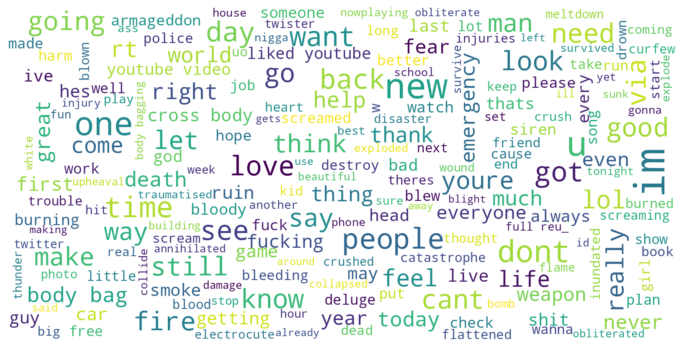

In [13]:
# Positive tweets wordcloud
formal_tweets = train_data[train_data.target == 0]
formal_string = []
for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**DATA VISUALIZATION:**

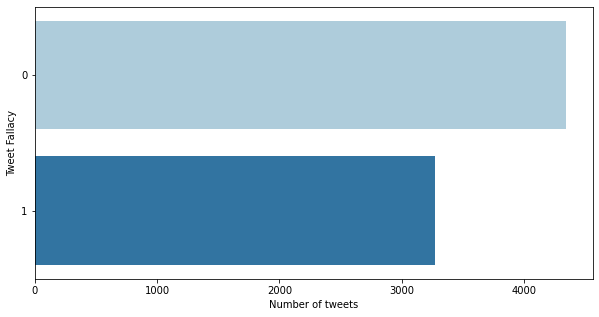

In [14]:
#Visualizing class distribution 
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = train_data,palette="Paired")
plt.ylabel("Tweet Fallacy")
plt.xlabel("Number of tweets")
plt.show()

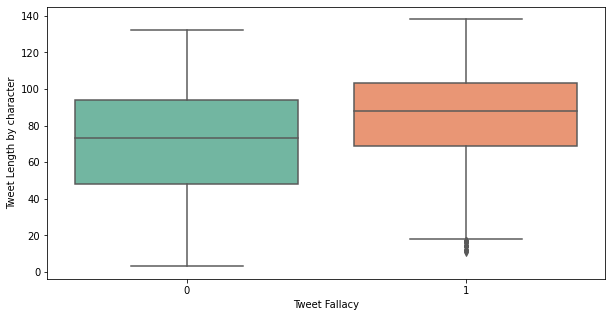

In [15]:
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set2")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet Length by character")
plt.show()

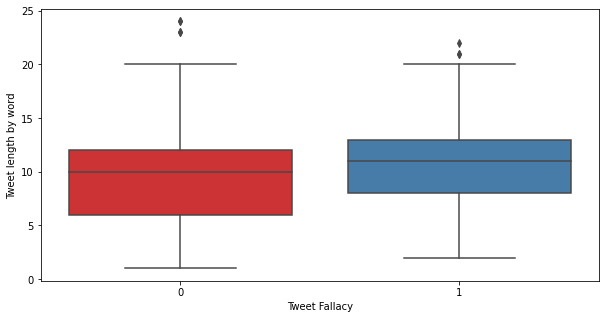

In [16]:
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

In [17]:
# word_count
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_data['url_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data['mean_word_length'] = train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['text'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['text'].apply(lambda x: len(str(x)))

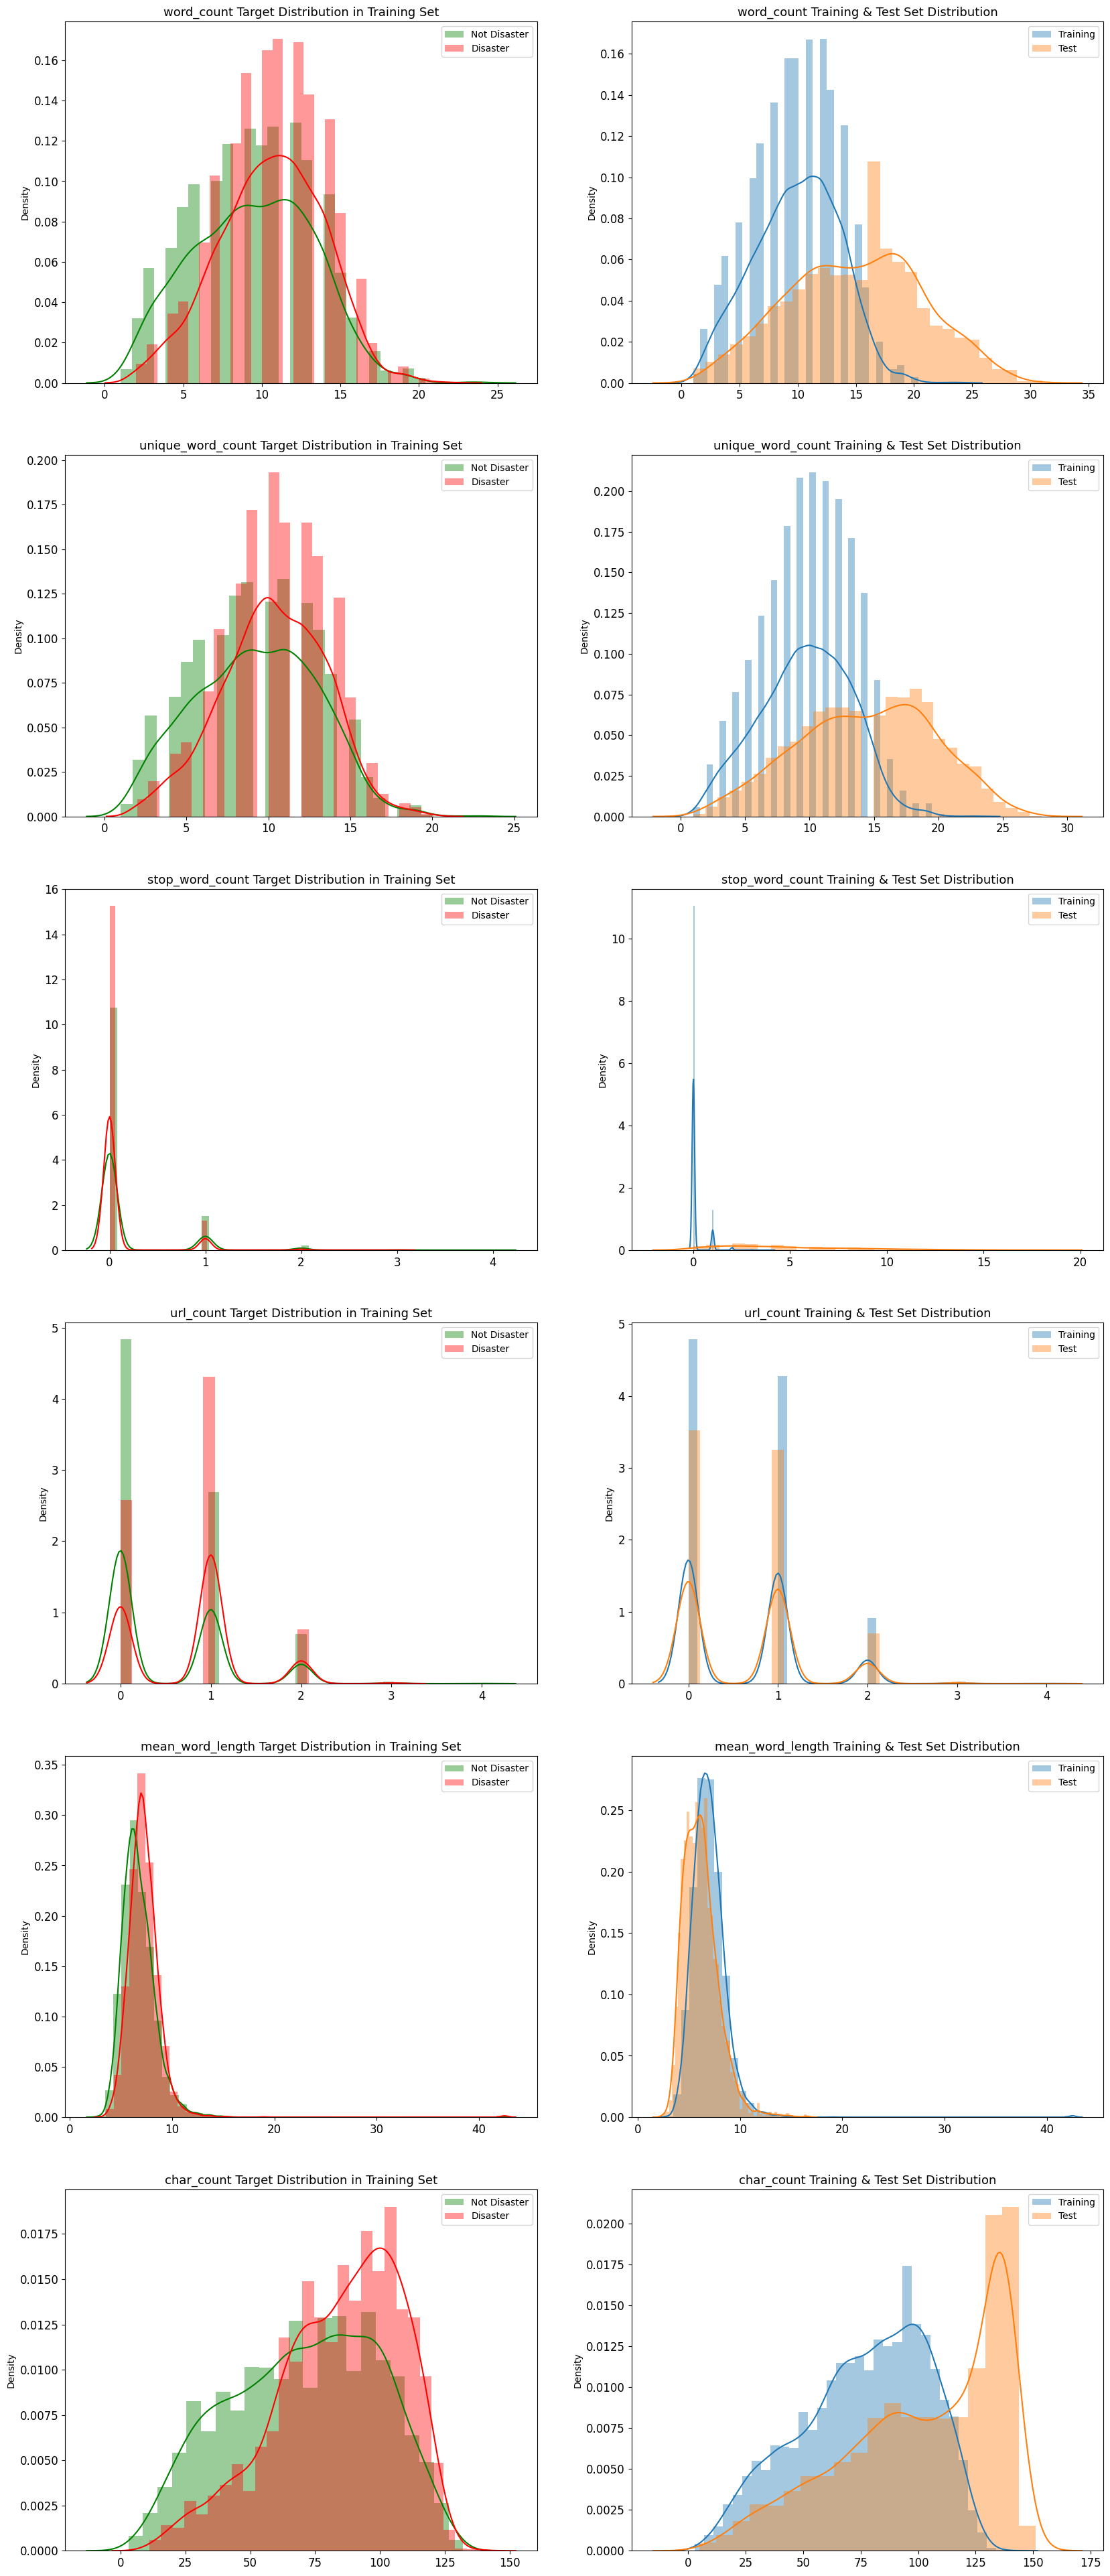

In [18]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = train_data['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_data.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

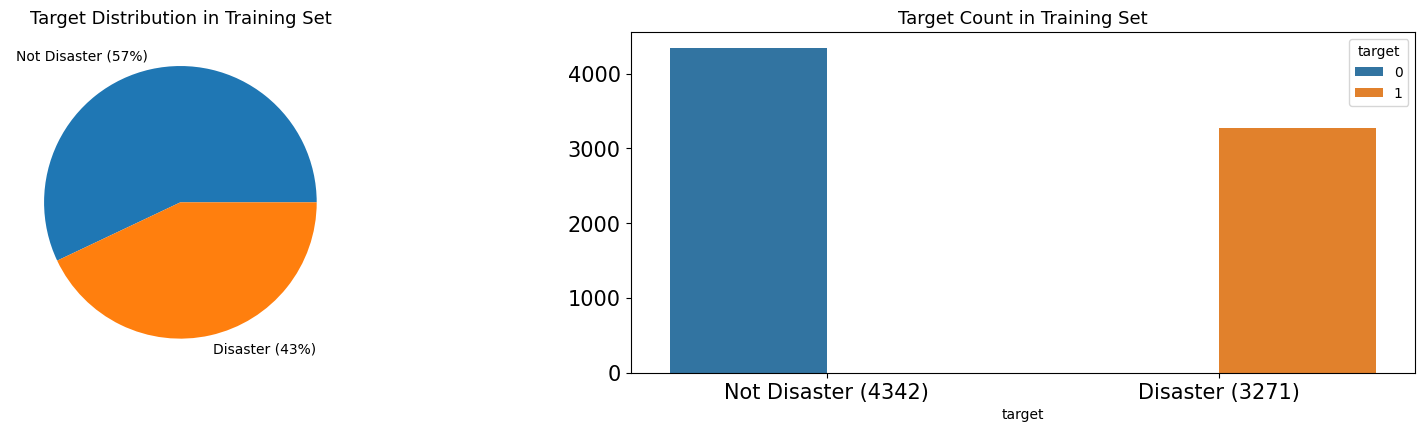

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_data.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train_data['target'], hue=train_data['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

**BERT - Bidirectional Encoder Representations from Transformers**

* BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

* The best part about BERT is that we can use the BERT models to extract high quality language features from our text data.

**LOADING THE BERT MODEL:**

In [20]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

2022-10-06 19:36:24.978923: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 19:36:24.980482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 19:36:24.981315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 19:36:24.981954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [21]:
tokenizer('Happy learning and keep kaggling &*&*&&')

{'input_ids': [101, 3407, 4083, 1998, 2562, 10556, 13871, 2989, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**CONVERSION OF OUR TEXT DATA INTO BERT INPUT FORMAT:**

In [22]:
print("max len of tweets",max([len(x.split()) for x in train_data.text]))
max_length = 36

max len of tweets 24


In [23]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [24]:
x_train['input_ids'].shape

TensorShape([7613, 36])

In [25]:
x_train['attention_mask'].shape

TensorShape([7613, 36])

In [26]:
y_train = train_data.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

**BUILDING THE MODEL ARCHITECTURE:**

In [28]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

# for training bert our lr must be so small


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 36)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 36)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 1024)         0           tf_bert_model[0][1]          

In [30]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


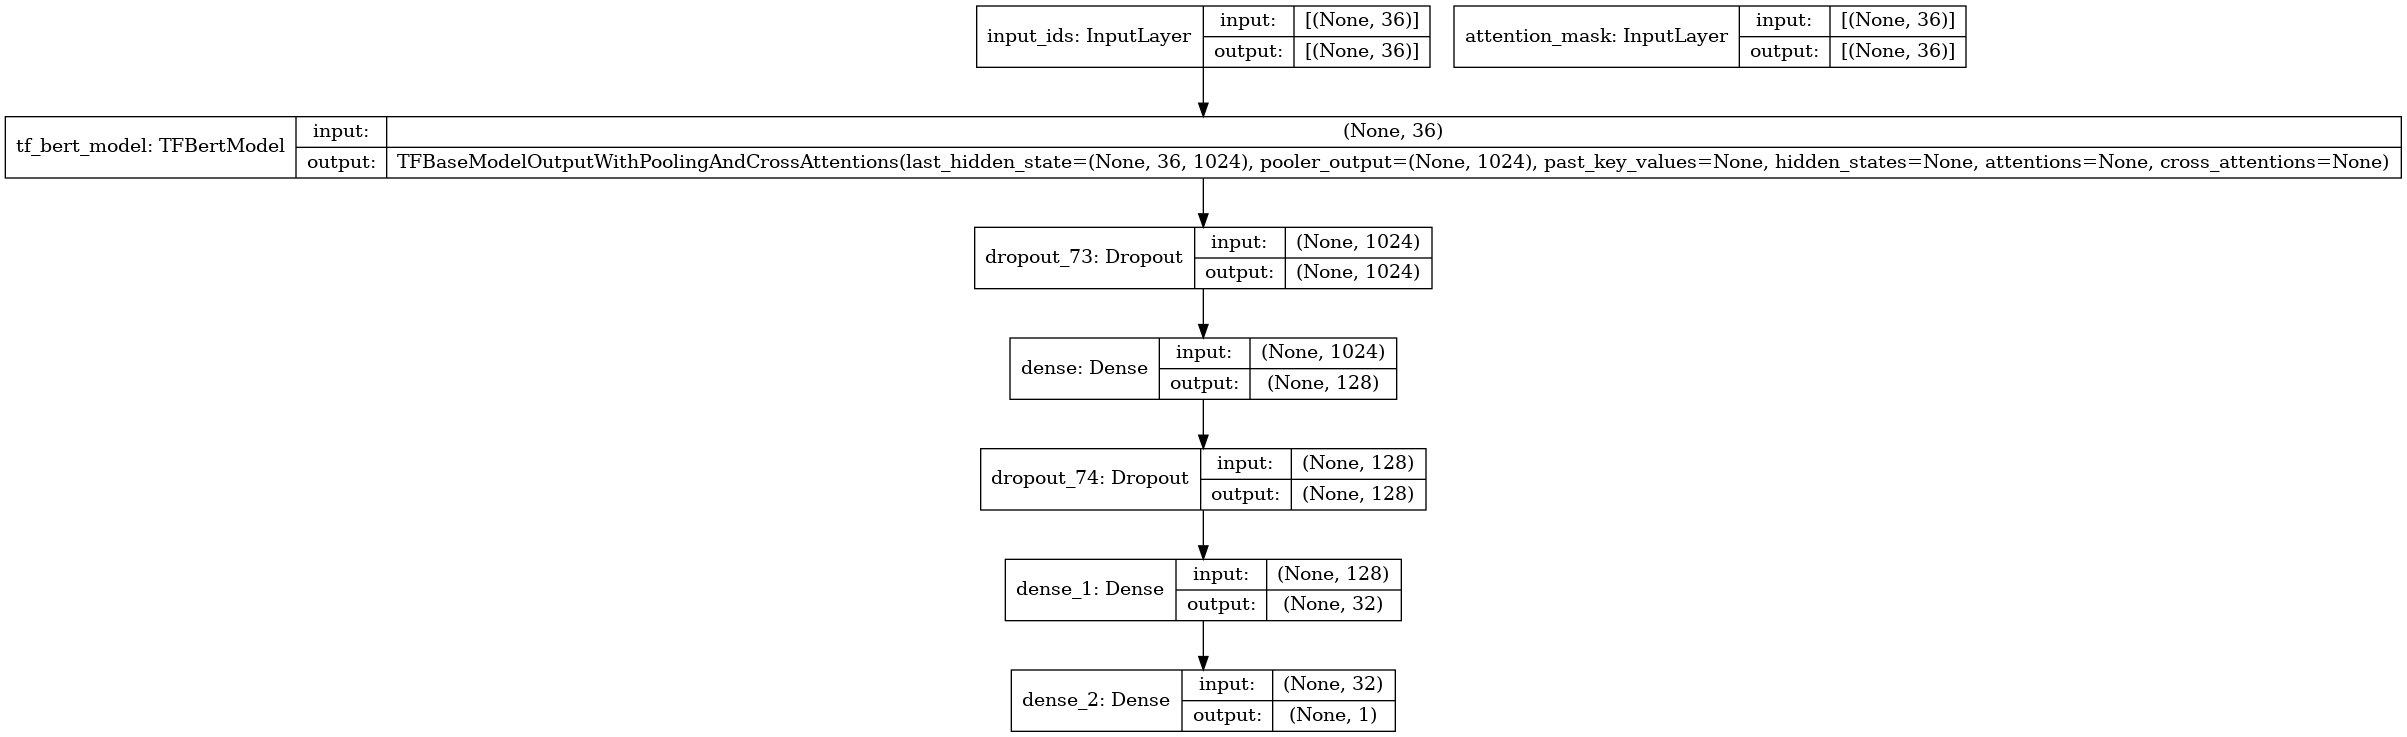

In [31]:
plot_model(model, show_shapes = True)

In [32]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=9,
    batch_size=10
)

2022-10-06 19:36:47.504897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/9
762/762 [==============================] - 214s 232ms/step - loss: 0.5112 - accuracy: 0.7691
Epoch 2/9
762/762 [==============================] - 177s 233ms/step - loss: 0.4220 - accuracy: 0.8291
Epoch 3/9
762/762 [==============================] - 177s 233ms/step - loss: 0.4032 - accuracy: 0.8345
Epoch 4/9
762/762 [==============================] - 177s 233ms/step - loss: 0.3887 - accuracy: 0.8394
Epoch 5/9
762/762 [==============================] - 177s 233ms/step - loss: 0.3863 - accuracy: 0.8428
Epoch 6/9
762/762 [==============================] - 177s 233ms/step - loss: 0.3780 - accuracy: 0.8464
Epoch 7/9
762/762 [==============================] - 177s 232ms/step - loss: 0.3762 - accuracy: 0.8470
Epoch 8/9
762/762 [==============================] - 177s 232ms/step - loss: 0.3722 - accuracy: 0.8505
Epoch 9/9
762/762 [==============================] - 177s 232ms/step - loss: 0.3724 - accuracy: 0.8493


**VISUALIZATION OF LOSS AND ACCURACY CURVE:**

In [33]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']
    epochs_plot = np.arange(1, len(loss) + 1)
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

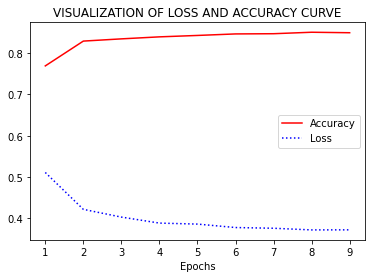

In [34]:
visual_accuracy_and_loss(final)

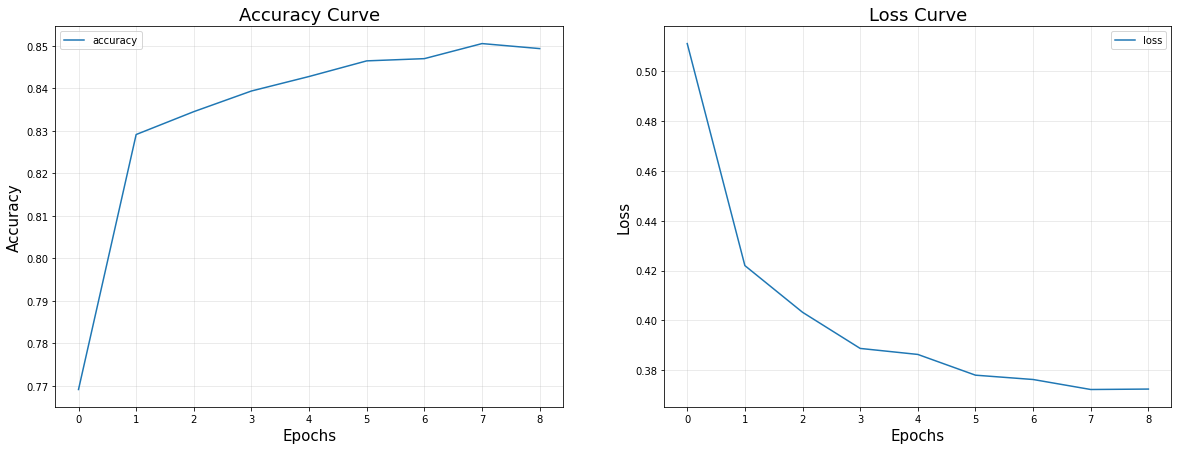

In [35]:
# Plot the loss and accuracy curves  

#Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(final.epoch,final.history['accuracy'],label = "accuracy") # Accuracy curve 


plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(final.epoch,final.history['loss'],label="loss") # Loss curve 


plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()


In [36]:
test_data

,id,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,0,Just happened a terrible car crash,6,6,2,0,4.833333,34
1,2,"Heard about #earthquake is different cities, s...",9,9,2,0,6.222222,64
2,3,"there is a forest fire at spot pond, geese are...",19,19,10,0,4.105263,96
3,9,Apocalypse lighting. #Spokane #wildfires,4,4,0,0,9.250000,40
4,11,Typhoon Soudelor kills 28 in China and Taiwan,8,8,2,0,4.750000,45
...,...,...,...,...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,8,7,0,0,6.000000,55
3259,10865,Storm in RI worse than last hurricane. My city...,23,22,7,0,5.086957,139
3260,10868,Green Line derailment in Chicago http://t.co/U...,6,6,1,1,8.333333,55
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,7,7,0,1,8.428571,65


In [37]:
x_test = tokenizer(
    text=test_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

**PREDICTION:**

In [38]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [39]:
y_predicted = np.where(predicted>0.5,1,0)

In [40]:
y_predicted = y_predicted.reshape((1,3263))[0]

In [41]:
sample_data['id'] = test_data.id
sample_data['target'] = y_predicted

In [42]:
sample_data.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [43]:
sample_data.to_csv('submission.csv',index = False)
print(" Successfully completed! ")

 Successfully completed! 
